In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
image = cv2.imread("/content/sink.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
#!yolo predict model=yolov8n.pt source='/content/JP020_001GL.jpeg'

Ultralytics YOLOv8.0.118 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients

image 1/1 /content/JP020_001GL.jpeg: 480x640 1 truck, 96.6ms
Speed: 15.6ms preprocess, 96.6ms inference, 45.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
results = model(source='/content/sink2.jpeg', conf=0.25, save=True,classes=[71])
#results = model.predict(source='/content/JP020_001GL.jpeg', conf=0.25)


image 1/1 /content/sink2.jpeg: 640x512 1 sink, 64.3ms
Speed: 2.5ms preprocess, 64.3ms inference, 22.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict5


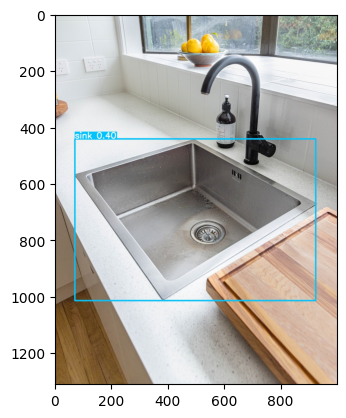

In [ ]:
import matplotlib.pyplot as plt

image = plt.imread("/content/runs/detect/predict5/sink2.jpeg")

# Display the image
plt.imshow(image)

# Show the plot
plt.show()


In [ ]:
print(results)

[ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

In [ ]:
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs

bbox=boxes.xyxy.tolist()[0]

In [ ]:
bbox
image = cv2.cvtColor(cv2.imread('/content/sink2.jpeg'), cv2.COLOR_BGR2RGB)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [ ]:
input_box = np.array(bbox)
print(input_box)

[     70.561      442.03      924.15      1015.2]


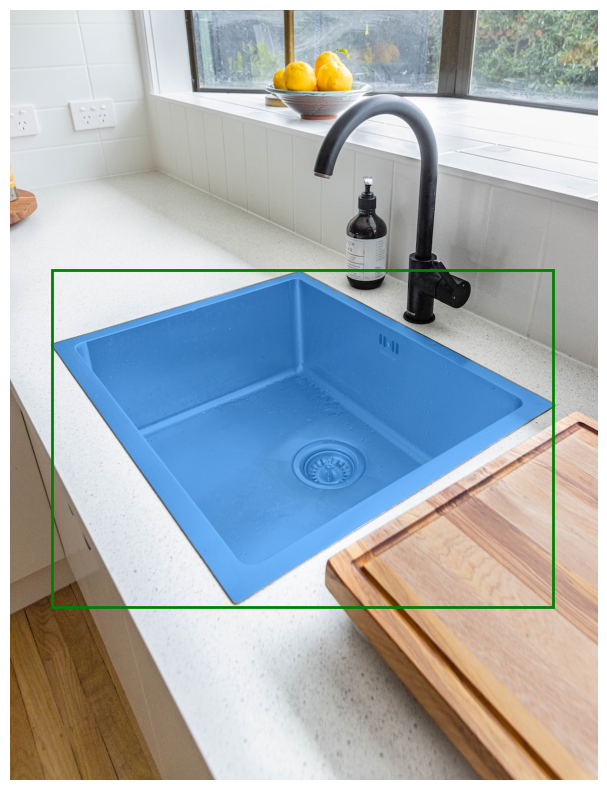

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

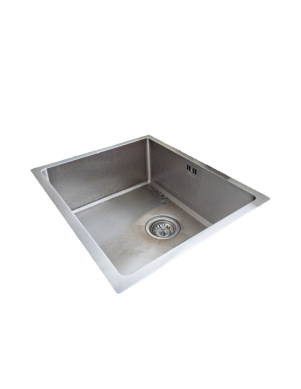

In [ ]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

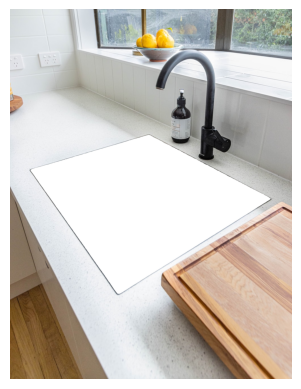

In [ ]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

# Create a copy of the original image
new_image = image.copy()

# Set the masked pixels to white
new_image[binary_mask == 1] = 255

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


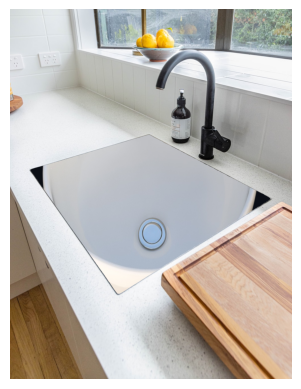

In [ ]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

# Load the replacement image
replacement_image = plt.imread("/content/WhatsApp Image 2023-06-20 at 12.08.49 PM.jpeg")

# Resize the replacement image to match the dimensions of the binary_mask
replacement_image = cv2.resize(replacement_image, (binary_mask.shape[1], binary_mask.shape[0]))

# Create a copy of the original image
new_image = image.copy()

# Replace the masked pixels with the replacement image
new_image[np.where(binary_mask)] = replacement_image[np.where(binary_mask)]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()
